In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.datasets import make_moons

from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.autograd.forward_ad import dual_level, make_dual, unpack_dual

import FrEIA.framework as Ff
import FrEIA.modules as Fm
import FrEIA.modules.splines as Fms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from plot import plot_contour_grid, plot_pdf, plot_contour_grid_torus

In [3]:
def get_jacobian_general(z, fwd_mode=False, transform=None, normalize_z=False, print_info=False):
    #accepts only flattened z and x as (N_samples, N_dims)
    assert transform is not None, 'transform must be provided for backward and forward mode'
    x = transform(z)
    assert z.shape[0] == x.shape[0], 'z and x must have the same number of samples'
    #assert z.shape[1] == x.shape[1], 'z and x must have the same number of dimensions'
    
    N_samples = z.shape[0]
    x_dim = x.shape[1]
    z_dim = z.shape[1]

    device = z.device

    full_jac_array = torch.zeros((N_samples, z_dim, x_dim)).to(device=device)
    if print_info:
        print('Computing Jacobian with backward autodiff')
    print_update_function = tqdm if print_info else lambda x: x

    if not fwd_mode:
        
        for i in print_update_function(range(x_dim)): #loop through all dims of x
            x_grad = grad((x).reshape(N_samples, -1)[:,i].sum(), z, create_graph=True, allow_unused=True)[0]
            #x_grad.detach()
            #print(x_grad.shape)
            full_jac_array[:,:,i] = x_grad.detach().to(device=device)
    else:
        for i in print_update_function(range(z_dim)):
            z_grad = torch.zeros_like(z)
            z_grad[:,i] = 1
            with dual_level():
                dual_z = make_dual(z, z_grad)
                dual_x = transform(dual_z)
                x_rec, x_grad = unpack_dual(dual_x)
            assert torch.allclose(x_rec, x), 'transformed x does not match original x'
            x_grad = x_grad.reshape(x_grad.shape[0], -1)
            full_jac_array[:,i,:] = x_grad.detach().to(device=device)

    if normalize_z:
        z_mean = z.mean(0)
        z_std = z.std(0)
        full_jac_array = full_jac_array * z_std[None, :, None]

    return full_jac_array

In [26]:
def get_loss(model, x, kwargs_loss):
    use_PF_exact = kwargs_loss['use_PF_exact'] #use the Principal Component Flows objective with the full Jacobian per batch element
    alpha = kwargs_loss['alpha']
    use_rec = kwargs_loss['use_rec']
    dims_rec = kwargs_loss['dims_rec']
    lam_rec = kwargs_loss['lam_rec']
    if use_PF_exact:
        assert 0 <= alpha <= 1, 'alpha must be between 0 and 1'
    if use_rec:
        assert lam_rec >= 0, 'lam_rec must be positive'

    z, ljd = model(x, rev=False) # pass through encoder
    N_dim = z.shape[1]

    ML_pz = 0.5*z**2 #prior is a standard normal

    ML = (ML_pz.sum(-1) - ljd).sum(0)
    
    if use_PF_exact:
        jac_dec = []
        x_rec, ljd_inv = model(z, rev=True) # pass through decoder
        for j in range(N_dim):
            jac_dec.append(grad(x_rec[:, j].sum(), z, create_graph=True)[0])
        jac_dec = torch.stack(jac_dec, axis=2)  #Jacobian of the decoder
        ljd_inv_i = 1/2*torch.log(torch.sum(jac_dec**2, axis=-1))

        ML           = torch.sum(ML_pz.sum(-1) - ljd, 0) #instead of '-ljd' we could also use '+ljd_inv' as the encoder and decoder are the inverse of each other
        PF_objective = torch.sum(ML_pz + ljd_inv_i,   0) #we use the decoder Jacobian columns as in the brute force implementation

        loss = ((1-alpha)*ML + torch.sum(alpha*PF_objective)) / x.numel()
    else:
        loss = ML.sum() / x.numel()

    if use_rec:
        z_rec = z.clone()
        z_rec[:, dims_rec] = 0
        x_rec, _ = model(z_rec, rev=True)
        MSE = ((x_rec-x)**2).mean()/N_dim
        loss += lam_rec*MSE
    else:
        MSE = torch.tensor(0.0).to(device)
    
    #loss is used for backpropagation
    #ML, MTC and MSE in losses_eval are used for evaluation during training

    losses_eval = {
        'ML': ML.sum() / x.numel(),
        'MSE': MSE,
    }
    return loss, losses_eval

In [5]:
def train(model, data_function, optimizer, losses, kwargs_data, kwargs_loss, N_iter=1000, manifold='two_moons', kwargs_man=None, theta=None, print_info=True, **kwargs):
    info_function = lambda x: x
    if print_info:
        info_function = lambda x: tqdm(x)

    for i in info_function(range(N_iter)):
        optimizer.zero_grad()
        x = torch.Tensor(data_function(kwargs_loss['batch_size'])).to(device)
        x.requires_grad = True

        # Normalize data
        x = (x - kwargs_data['data_mean']) / kwargs_data['data_std']
        
        # Inflate manifold with normal noise
        x_noise = torch.randn_like(x)*kwargs_data['noise_sigma']
        x = x + x_noise

        loss, losses_eval = get_loss(model, x, kwargs_loss)

        ML = losses_eval['ML']
        MSE = losses_eval['MSE']

        loss.backward()
        losses['ML'] = np.append(losses['ML'], ML.cpu().detach().numpy())
        losses['MSE'] = np.append(losses['MSE'], MSE.cpu().detach().numpy())
        optimizer.step()

In [6]:
def INN_init(N_DIM, N_blocks = 8, conditions = 0, act_func='relu', ch_hidden=None, bins=None, coupling_block = 'GLOW', clamp=2.0, permute_soft=False, permute_hard=True, householder_perms=2, use_actnorms=True, lr=1e-3, device=None):
    def subnet_fc(c_in, c_out, ch_hidden=128, act_func='relu', layers=3):
        if act_func == 'relu':
            act_func = nn.ReLU()
        elif act_func == 'tanh':
            act_func = nn.Tanh()
        else:
            act_func = nn.ReLU()
        subnet = nn.Sequential()
        subnet.append(nn.Linear(c_in, ch_hidden))
        subnet.append(act_func)
        for i in range(layers-2):
            subnet.append(nn.Linear(ch_hidden, ch_hidden))
            subnet.append(act_func)
        subnet.append(nn.Linear(ch_hidden,  c_out))
        subnet[-1].weight.data.zero_()
        subnet[-1].bias.data.zero_()
        return subnet

    if bins == None:
        bins = 10

    flow = Ff.SequenceINN(N_DIM)

    subnet_fc_temp = lambda c_in, c_out: subnet_fc(c_in, c_out, act_func=act_func, ch_hidden=ch_hidden, layers=3)
    
    cond = None
    cond_shape = None
    try:
        if conditions > 0:
            cond = 0
            cond_shape = (conditions,)
    except:
        pass

    for k in range(N_blocks):
        if coupling_block == 'GLOW':
            flow.append(Fm.GLOWCouplingBlock, cond=cond, cond_shape=cond_shape, subnet_constructor=subnet_fc_temp, clamp=clamp)
        elif coupling_block == 'All':
            flow.append(Fm.AllInOneBlock, cond=cond, cond_shape=cond_shape, subnet_constructor=subnet_fc_temp, permute_soft=True)
        elif coupling_block == 'RQS':
            flow.append(Fms.RationalQuadraticSpline, cond=cond, cond_shape=cond_shape, bins=bins, subnet_constructor=subnet_fc_temp)
        elif coupling_block == 'GIN':
            flow.append(Fm.GINCouplingBlock, cond=cond, cond_shape=cond_shape, subnet_constructor=subnet_fc_temp)
        elif coupling_block == 'NICE':
            flow.append(Fm.NICECouplingBlock, cond=cond, cond_shape=cond_shape, subnet_constructor=subnet_fc_temp)
        else:
            raise ValueError('Incompatible coupling_block name')
        
        if permute_hard:
            flow.append(Fm.PermuteRandom)
        if permute_soft:
            flow.append(Fm.HouseholderPerm, n_reflections=householder_perms, fixed=True)
        if use_actnorms:
            flow.append(Fm.ActNorm)
    
    parameters = []
    for p in flow.parameters():
        parameters.append(p)

    optimizer_flow = torch.optim.Adam(parameters, lr=lr, weight_decay=1e-5) #torch.optim.SGD(parameters, lr=lr)
            
    flow = flow.to(device)
    losses = {
    'ML': [],
    'MSE': [],
    }
    return flow, optimizer_flow, losses

In [7]:
def get_decoder_jac(model, kwargs_data, N_samples=1000, z_input=None, x_input=None, print_info=True):
    N_dim = kwargs_data['N_dim']
    device = kwargs_data['device']

    data_mean = kwargs_data['data_mean']
    data_std = kwargs_data['data_std']

    if z_input is not None:
        z = z_input
        N_samples = z.shape[0]
    elif x_input is not None:
        x = x_input
        N_samples = x.shape[0]
        x = (x - data_mean) / data_std
        z, _ = model(x, rev=False)
        z = z.detach().requires_grad_(True)
    else:
        z = torch.randn(N_samples, N_dim).to(device)
        z.requires_grad = True

    if print_info: #use tqdm
        update_func = lambda x: tqdm(x)
    else:
        update_func = lambda x: x

    full_jac_array = torch.zeros((N_samples, N_dim, N_dim)).to(device)
    if print_info:
        print('Computing Jacobian with backward autodiff')
    
    x, ljd = model(z, rev = True) # Run the model in reverse to obtain generated samples and ljd
    
    x = x * data_std + data_mean # renormalize x as we compute the jacobian in the original data space before normalization
    
    for i in update_func(range(N_dim)): #loop through all dims of x
        x_grad = grad((x).reshape(N_samples, -1)[:,i].sum(), z, create_graph=True)[0]# 
        full_jac_array[:,:,i] = x_grad.detach().to(device)
        del x_grad

    return full_jac_array.detach().to(device), ljd.detach().to(device), z.detach().to(device), x.detach().to(device)

In [8]:
def get_manifold_entropy(kwargs_data, full_jac_array, ljd_array, add_constant=True, print_info=True):
    N_dim = kwargs_data['N_dim']
    #device = kwargs_data['device']
    #dtype = kwargs_data['dtype']

    #data_mean = kwargs_data['data_mean']
    data_std = kwargs_data['data_std']

    if add_constant:
        NLL_pz = torch.tensor([1/2*(1+np.log(2*np.pi))]).repeat(N_dim) #entropy of the prior
    else:
        NLL_pz = torch.zeros((N_dim), dtype=torch.float32)

    H_full = (ljd_array + N_dim*torch.log(data_std) + NLL_pz.sum(0)).mean() #we add log(data_std) to the entropy as we compute the entropy in the original data space
    H_i = torch.zeros((N_dim), dtype=torch.float32)

    update_func = lambda x: x
    if print_info:
        update_func = lambda x: tqdm(x)

    for i in update_func(range(N_dim)):
        H_i[i] = torch.mean(1/2*torch.log(torch.sum(full_jac_array[:,i,:]**2, -1)), -1) + NLL_pz[i]

    latent_sort = torch.argsort(H_i, descending=True)
    
    return H_i, H_full, latent_sort

In [9]:
def get_manifold_pairwise_mutual_information(jac_1, jac_2, N_dim_max=None, dtype=torch.float64, device='cpu', print_info=True): #computes the manifold mutual information between two jacobians
    assert jac_1.shape == jac_2.shape

    jac_1 = jac_1.to(device=device).to(dtype=dtype)
    jac_2 = jac_2.to(device=device).to(dtype=dtype)

    if (jac_1 == jac_2).all():
        comp_cross = False
    else:
        comp_cross = True

    if N_dim_max is None:
        N_dim_max = jac_1.shape[1]
    MPMI_ij = torch.zeros((10, N_dim_max, N_dim_max), dtype=dtype).to(device=device)

    if jac_1.dim() == 3:
        jac_1 = jac_1.unsqueeze(0)
    if jac_2.dim() == 3:
        jac_2 = jac_2.unsqueeze(0)
    
    assert jac_1.dim() == 4

    #precompute jac_det_i
    jac_det_1i = torch.log(torch.sum(jac_1[:,:,:,:]**2, -1))
    jac_det_2i = torch.log(torch.sum(jac_2[:,:,:,:]**2, -1))

    update_func = lambda x: x
    if print_info:
        update_func = lambda x: tqdm(x)
        print(f'Computing {'MCPMI' if comp_cross else 'MPMI'} matrix')

    for i in update_func(range(N_dim_max)):
        second_range = range(N_dim_max) if comp_cross else range(i+1, N_dim_max)
        idx = torch.tensor([i,0])
        for j in second_range:

            idx = torch.tensor([i,j])#.to(device='cuda')
            submatrix = torch.cat((jac_1[:,:,idx[0],:].unsqueeze(2), jac_2[:,:,idx[1],:].unsqueeze(2)), 2)
            GTG = torch.einsum('xyij, xykj -> xyik', submatrix, submatrix)

            jac_det_12 = GTG[...,0,0]*GTG[...,1,1] - GTG[...,0,1]*GTG[...,1,0]
            jac_det_12 = torch.log(jac_det_12)

            jac_det_1 = jac_det_1i[:,:,idx[0]]
            jac_det_2 = jac_det_2i[:,:,idx[1]]
            if jac_det_1.isnan().any() or jac_det_2.isnan().any() or jac_det_12.isnan().any():
                print('Is nan!')
                print(jac_det_1)
                print(jac_det_2)
                print(jac_det_12)
                return

            MPMI_ij[:,i,j] = - 1/2*torch.mean(jac_det_12 - jac_det_1 - jac_det_2, -1).to(device=device).to(dtype=dtype)

    MPMI_ij = MPMI_ij.mean(0)
    return MPMI_ij.to(device=device).to(dtype=dtype)

# 1. Two Moons

## Init

In [108]:
N_dim = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [109]:
flow, optimizer_flow, losses = INN_init(N_DIM = 2, N_blocks = 4, coupling_block = 'RQS', ch_hidden=128, bins=4, permute_soft=False, permute_hard=False, householder_perms=2, use_actnorms=False, lr=1e-3, device=device)

In [110]:
kwargs_loss = {
    'batch_size': 1024,
    'use_PF_exact': False, #additionally minimize the Manifold Total Correlation
    'alpha': 1,
    'use_rec': False, #additionally minimize reconstruction loss via MSE
    'lam_rec': 1,
    'dims_rec': torch.tensor([1]), #latent dimensions which are set to zero for reconstruction loss
    'use_latent_sorting': False
}

In [111]:
kwargs_data = {
    'noise_sigma': 0.1, #standard deviation of the normal noise added to the data
    'N_dim': N_dim,
    'device': device,
    'dtype': torch.float32,
    'get_data' : None,
    'data_mean': torch.tensor([0.0]).to(device),
    'data_std': torch.tensor([1.0]).to(device),
}

## Training

In [112]:
data_function = (lambda batchsize: make_moons(n_samples=batchsize, noise=0)[0])
train(flow, data_function, optimizer_flow, losses, kwargs_data, kwargs_loss, N_iter=1000)

100%|██████████| 1000/1000 [00:38<00:00, 25.84it/s]


In [154]:
optimizer_flow.param_groups[0]['lr'] = 1e-4

In [168]:
optimizer_flow

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)

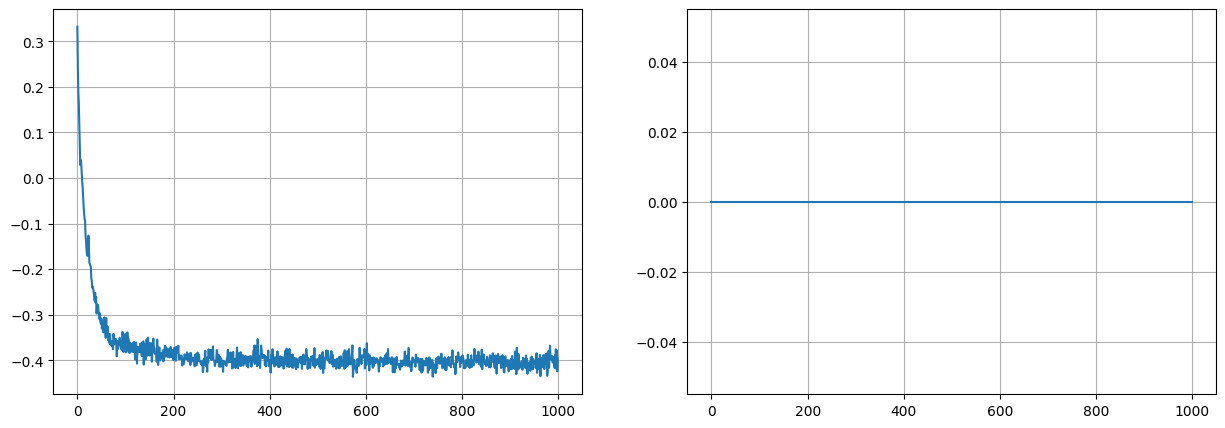

In [113]:
#plot loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(losses['ML'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(losses['MSE'])
plt.grid()

plt.show()

## Generate Samples

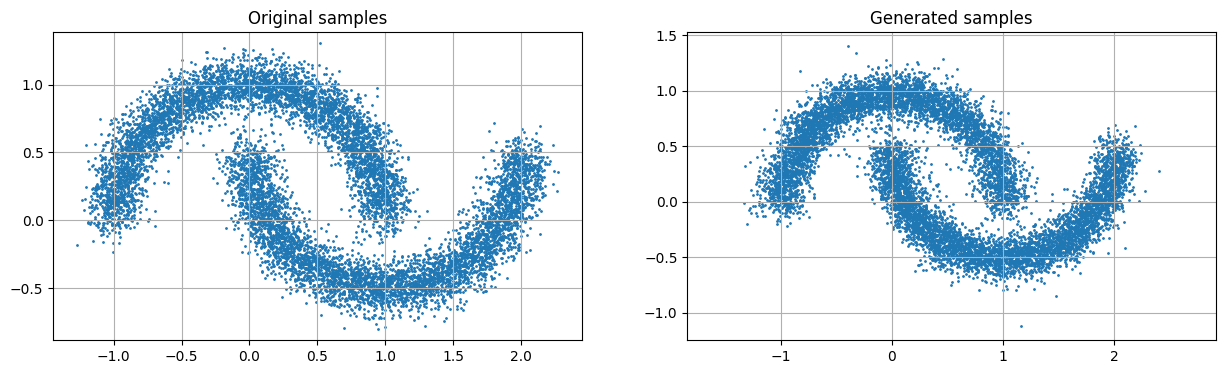

In [114]:
N_samples = 10000

#plot original samples
x = torch.Tensor(make_moons(n_samples=N_samples, noise=0)[0]).to(device)
x = x + torch.randn_like(x)*kwargs_data['noise_sigma']

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.title('Original samples')
plt.scatter(x.cpu().detach().numpy()[:,0], x.cpu().detach().numpy()[:,1], s=1)
plt.grid()
plt.xlim(x_range)
plt.ylim(y_range)
plt.axis('equal')

#plot generated samples 
z = torch.randn(N_samples, 2).to(device)
x, _ = flow(z, rev=True)
#renormalize
x = x*kwargs_data['data_std'] + kwargs_data['data_mean']
x = x.cpu().detach().numpy()

plt.subplot(1,2,2)
plt.title('Generated samples')
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.grid()
plt.xlim(x_range)
plt.ylim(y_range)
plt.axis('equal')

plt.show()

In [115]:
import importlib
import plot
importlib.reload(plot)
from plot import plot_contour_grid, plot_pdf, plot_contour_grid_torus

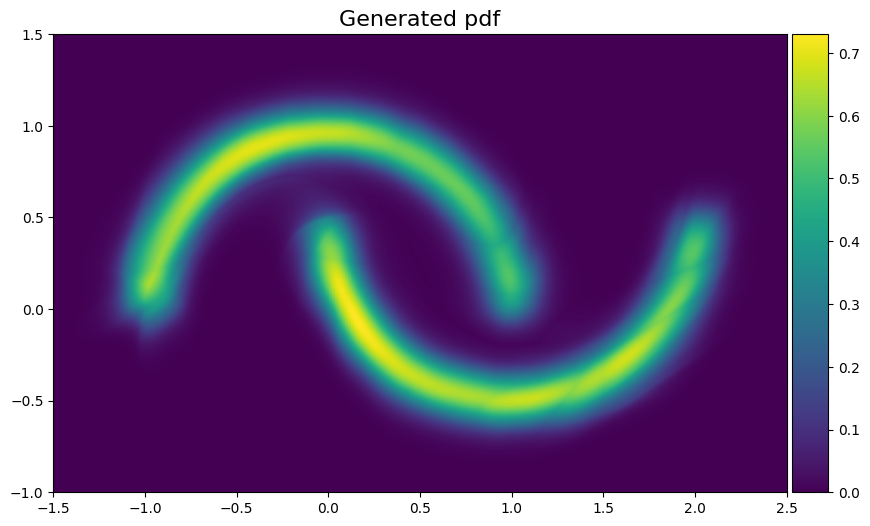

In [116]:
figsize = 10
samples_size = 0.5
linewidth = 1
manifold_size = 5 #20
N_samples = 1000
N_manifold_samples = 10000 #1000
x_range, y_range = [-1.5,2.5], [-1.0,1.5]
#data_function = lambda N_samples_manifold: make_moons(n_samples=N_samples_manifold, noise=0)[0]

fig, axes = plt.subplots(1, 1, figsize=(figsize, figsize), squeeze=False, constrained_layout=False)
axes = axes.flatten()

plot_pdf(N_samples_manifold=N_manifold_samples, resolution=500, model=flow, show_original_manifold=False, show_pred_manifold=False, data_function=data_function, N_dim=2, x_range=x_range, y_range=y_range, c_range=None, figsize=figsize, plot_image=True, save_image=False, save_folder=None, info=None, title='Generated pdf', fontsize=16, device=device, N_contours = None, no_plot=True, fig=fig, axes=axes, use_colorbar=True, constrained_layout=False, axis_off=False, output_filetype=False)

plt.show()

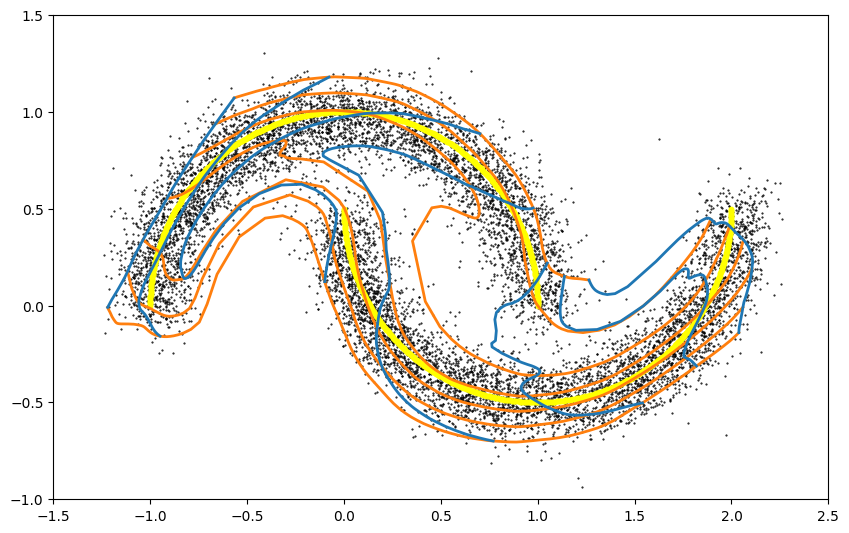

In [117]:
figsize = 10
samples_size = 1
linewidth = 2
pred_manifold_linewidth = 3
manifold_size = 10

N_samples = 10000
N_manifold_samples = 1000
x_range, y_range = [-1.5,2.5], [-1.0,1.5]

data_function = lambda BATCHSIZE: make_moons(n_samples=BATCHSIZE, noise=0)[0]

show_original_manifold  = True
show_pred_manifold      = False

plot_contour_grid(model=flow, N_DIM=2, BATCHSIZE_samples = N_samples, BATCHSIZE_manifolds=N_manifold_samples, show_samples=True, show_contour_grid=True, show_original_manifold=show_original_manifold, show_pred_manifold=show_pred_manifold, figsize=figsize, title=None, data_function=data_function, alpha=1, x_range=x_range, y_range=y_range, N_maj_ticks = 7, N_min_ticks = 50, samples_size=samples_size, manifold_size=manifold_size, linewidth=linewidth, pred_manifold_linewidth=pred_manifold_linewidth, grid_scaling=1.0, fontsize=None)

## Manifold Entropic Evaluation

In [118]:
#first compute the full Jacobian matrix
jac, ljd, z, x = get_decoder_jac(flow, kwargs_data, N_samples=10000, print_info=False)
#compute the manifold entropy
H_i, H_full, latent_sort = get_manifold_entropy(kwargs_data, jac, ljd, add_constant=False, print_info=False)
#sort the latent dimensions by the entropy
H_i_sort = H_i[latent_sort].cpu().detach().numpy()
#compute Total Correlation
MTC = (H_i.sum() - H_full).item()
H_full = H_full.item()
H_c = H_i[0].item()
H_d = H_i[1].item()

print('Manifold Total Corelation between all latent dimensions:', MTC)
print('Full Entropy:', H_full)
print('Manifold Entropy of the first latent dimension:', H_c)
print('Manifold Entropy of the second latent dimension:', H_d)


Manifold Total Corelation between all latent dimensions: 0.7769802808761597
Full Entropy: -1.8006614446640015
Manifold Entropy of the first latent dimension: -0.14742763340473175
Manifold Entropy of the second latent dimension: -0.8762534856796265


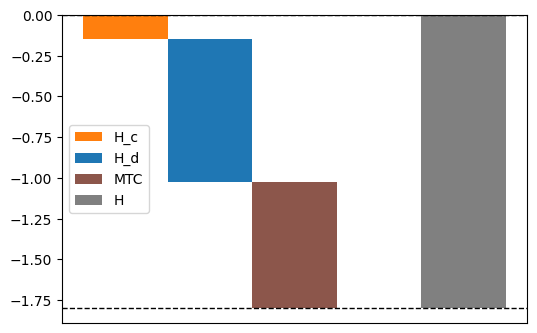

In [119]:
#plot NLL_i and NLL as bar plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

x_array = np.array([0, 0.5, 1, 2])

#horizontal line at zero
ax.axhline(0, color='black', lw=1, ls='--')

ax.bar(x_array[0], [H_c], width=0.5, label='H_c', color='tab:orange')
ax.bar(x_array[1], [H_d], width=0.5, bottom=[H_c], label='H_d', color='tab:blue')
ax.bar(x_array[2], [-MTC], width=0.5, bottom=[H_c + H_d], label='MTC', color='tab:brown')
ax.bar(x_array[3], [H_full], width=0.5, label='H', color='gray')

ax.axhline(H_full, color='black', lw=1, ls='--')

plt.legend()
#remove xticks
ax.set_xticks([])
plt.show()

# 2. 10-D Torus

## Init

In [30]:
def toroidal_to_cartesian(input):
    """
    Converts a batch of toroidal coordinates to Cartesian coordinates.

    Input dimension must be divisible by 2.

    Args:
    r: A tensor of shape (B, N/2), representing the radii.
    theta: A tensor of shape (B, N/2), representing the toroidal angles.

    Returns:
    cartesian_coords: A tensor of shape (B, N), the Cartesian coordinates.
    """
    N_dim = input.shape[1]
    assert N_dim % 2 == 0, "Input dimension must be divisible by 2."
    theta, r = input[:, :N_dim//2], input[:, N_dim//2:]
    B, N_over_2 = theta.shape
    #N = N_over_2 * 2
    
    # Compute the sine and cosine values
    sin_vals = torch.sin(theta)
    cos_vals = torch.cos(theta)

    #combine sin and cos values into angles by interleaving
    cartesian_coords = torch.zeros((B, N_dim), device=theta.device)
    cartesian_coords[:, 0::2] = r*cos_vals
    cartesian_coords[:, 1::2] = r*sin_vals

    return cartesian_coords

In [31]:
def cartesian_to_toroidal(input):
    """
    Converts a batch of Cartesian coordinates to toroidal coordinates.
    
    Args:
    input: A tensor of shape (B, N), where B is the batch size and N is the number of Cartesian coordinates.
    
    Returns:
    r: A tensor of shape (B, N/2), the radii.
    theta: A tensor of shape (B, N/2), the toroidal angles.
    """
    # Reshape the input to separate the x and y coordinates
    N_dim = input.shape[1]
    assert N_dim % 2 == 0, "Input dimension must be divisible by 2."
    input = input.reshape(-1, N_dim//2, 2)
    input = input.permute(0, 2, 1)

    # Compute the radii and angles
    r = torch.norm(input, dim=1)
    theta = torch.atan2(input[:, 1], input[:, 0])

    out = torch.cat((theta, r), dim=1)
    return out

In [32]:
def get_jacobian_general(z, x, fwd_mode=False, transform=None, normalize_z=False, print_info=False):
    """
    Computes the Jacobian of x towards z via a general transform function using autodiff.
    z: The input tensor.
    x: The output tensor.
    fwd_mode: If True, computes the Jacobian in forward mode, otherwise in backward mode.
    transform: The transformation function.
    normalize_z: If True, normalizes the Jacobian by the standard deviation of z.
    print_info: If True, prints the progress of the computation.
    """
    assert z.shape[0] == x.shape[0], 'z and x must have the same number of samples'
    #assert z.shape[1] == x.shape[1], 'z and x must have the same number of dimensions'
    N_samples = z.shape[0]
    x_dim = x.shape[1]
    z_dim = z.shape[1]

    device = z.device

    full_jac_array = torch.zeros((N_samples, z_dim, x_dim)).to(device=device)
    if print_info:
        print('Computing Jacobian with backward autodiff')
    print_update_function = tqdm if print_info else lambda x: x

    if not fwd_mode:
        for i in print_update_function(range(x_dim)): #loop through all dims of x
            x_grad = grad((x).reshape(N_samples, -1)[:,i].sum(), z, create_graph=True, allow_unused=True)[0]
            #x_grad.detach()
            #print(x_grad.shape)
            full_jac_array[:,:,i] = x_grad.detach().to(device=device)
    else:
        assert transform is not None, 'transform must be provided for forward mode'
        for i in print_update_function(range(z_dim)):
            z_grad = torch.zeros_like(z)
            z_grad[:,i] = 1
            with dual_level():
                dual_z = make_dual(z, z_grad)
                dual_x = transform(dual_z)
                x_rec, x_grad = unpack_dual(dual_x)
            #x_grad = x_grad.reshape(x_grad.shape[0], -1)
            full_jac_array[:,i,:] = x_grad.detach().to(device=device)

    if normalize_z:
        z_std = z.std(0)
        full_jac_array = full_jac_array * z_std[None, :, None]

    return full_jac_array

In [33]:
def get_data(kwargs_data, N_samples, get_all=False):
    N_dim = kwargs_data['N_dim']
    device = kwargs_data['device']
    noise_sigma = kwargs_data['noise_sigma']
    rot = kwargs_data['rot']
    sigmas = kwargs_data['sigmas'] #variances [N_dim-1] for angles

    assert N_dim % 2 == 0

    if get_all:
        z = torch.randn(N_samples, N_dim, requires_grad=True).to(device)
    else:
        z = torch.randn(N_samples, N_dim).to(device)

    z = z

    data_tor_ang = z[:, 0:N_dim//2] * sigmas[:N_dim//2].unsqueeze(0) + torch.pi/2#*2*torch.pi
    data_tor_rad =  (torch.ones(N_samples, N_dim//2).to(device) + z[:, N_dim//2:N_dim].to(device)*sigmas[N_dim//2:N_dim].unsqueeze(0))

    data_tor = torch.cat([data_tor_ang, data_tor_rad], dim=1)
    x = toroidal_to_cartesian(data_tor)

    #move to origin for better plotting
    offset = torch.ones(N_dim).to(device)
    offset[::2] = 0
    x = x - offset
    #orthogonal noise
    if N_dim < N_dim:
        x = torch.cat([x, z[:,N_dim:] * noise_sigma], dim=1)
    assert x.shape[1] == N_dim
    #rotate
    x = torch.mm(x, rot)
    assert x.shape[1] == N_dim

    if get_all:
        x = x
        full_jac_array = get_jacobian_general(z, x, normalize_z=True)

        assert full_jac_array.shape[1] == N_dim
        assert full_jac_array.shape[2] == N_dim
        
        return x, z, full_jac_array
    
    return x

In [34]:
def normalize_dist(kwargs_data, averaged=False):
    x = get_data(kwargs_data, N_samples=100000)
    mean = x.mean(dim=0)
    if averaged:
        mean = mean.mean()
    std = x.std()
    return mean, std

In [35]:
N_dim = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sigmas = torch.ones(N_dim).to(device)
#Angular variances
sigmas[:N_dim//2] = torch.exp(torch.linspace(-1.5, 0, N_dim//2).flip(0).float()*1).to(device)*2*torch.pi * 0.07
#Radial variances
sigmas[N_dim//2:] = torch.exp(torch.linspace(-1.5, 0, N_dim//2).flip(0).float()*1).to(device)*0.05
noise_sigma = sigmas[-1].item()
# initialize random orthogonal matrix
rot = torch.nn.init.orthogonal_(torch.eye(N_dim).to(device))

kwargs_data = {
    'N_dim': N_dim,
    'device': device,
    'dtype': torch.float32,
    'sigmas': sigmas,
    'noise_sigma': noise_sigma, #not used
    'rot': rot,
}
# Compute mean and std
data_mean, data_std = normalize_dist(kwargs_data, averaged=True)
kwargs_data['data_mean'] = data_mean
kwargs_data['data_std'] = data_std
kwargs_data['rot'] = rot

In [36]:
N_plots = 6
if N_dim > 2 * N_plots:
    dims_plot = np.linspace(0, N_dim - 1, N_plots, dtype=int)
    dims_plot = np.where(dims_plot % 2 == 0, dims_plot, dims_plot - 1)
else:
    dims_plot = np.arange(0, N_dim, 2)

x_range = [-1.5, 1.5] #[-1.5, 1.5]
y_range = [-1.5, 1.5] #[-2.5, 0.5]

## Plot original data

In [37]:
def plot_data(x, ax, dim_1, dim_2, color=None, s=1, x_range=None, y_range=None, use_arrow_gradient=False, x_grad=None, vmin=None, vmax=None, alpha=1, marker='.'):
    base_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    #if color is int
    if isinstance(color, int):
        color = base_colors[color]
    #check if color is a list
    if not use_arrow_gradient:
        if isinstance(color, str):
            ax.scatter(x[:, dim_1], x[:, dim_2], s=s, color=color, alpha=alpha, marker=marker, edgecolors='none')
        else:
            ax.scatter(x[:, dim_1], x[:, dim_2], s=s, c=color, alpha=alpha, cmap='bwr', vmin=vmin, vmax=vmax, marker=marker, edgecolors='none')
    else:
        ax.quiver(x[:, dim_1], x[:, dim_2], x_grad[:, dim_1], x_grad[:, dim_2], color=color, alpha=alpha, scale=s)
    if x_range is not None:
        ax.set_xlim(x_range)
    if y_range is not None:
        ax.set_ylim(y_range)
    ax.set_aspect('equal', 'box')
    ax.grid(True)

In [38]:
x_orig, z_gt, jac_orig = get_data(kwargs_data, N_samples=10000, get_all=True)

x_orig_unrotated = x_orig.clone().cpu().detach().numpy()
#apply rot in reverse
rot = kwargs_data['rot']
x_orig = torch.mm(x_orig, rot.t())
#jac_orig = jac_orig@rot.t()
#jac_orig = jac_orig.cpu().detach().numpy()

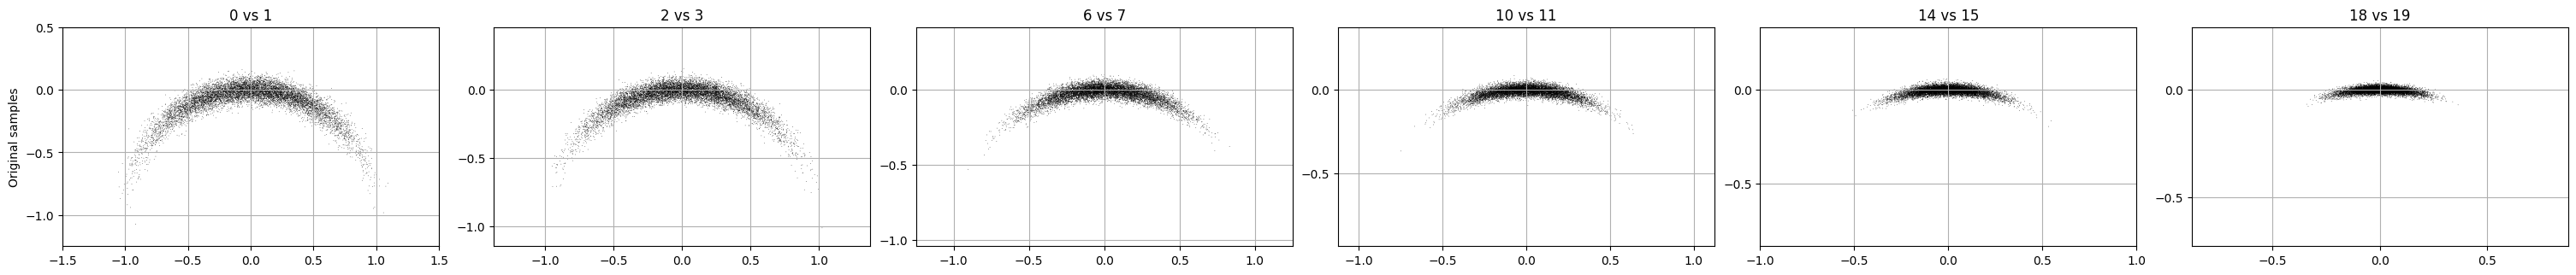

In [39]:
#dims_plot = np.arange(0, N_dim, 2)
#compare all dimensions pairwise from dims_plot in a 2D plot
fig, ax = plt.subplots(1, len(dims_plot), figsize=(30, 6), constrained_layout=True, squeeze=False)

i = 0
ax[0, 0].set_ylabel('Original samples')

for dim_1 in dims_plot:
    dim_2 = dim_1 + 1
    ax[0, i].set_title(f'{dim_1} vs {dim_2}')

    x_scale = 1.5-1*(i/8) #1.5*(1+i)**(-1.0) #1.5-1*(i/8) #1.5-1*(i/4)
    x_range, y_range = [-x_scale, x_scale], [-(x_scale/1.2), (x_scale/3)]

    plot_data(x_orig.cpu().detach().numpy(), ax[0, i], dim_1, dim_2, color='black', s=1, alpha=1, marker='.', x_range=x_range, y_range=y_range)
    #ax[0, i].set_xticks(ticks=np.arange(x_range[0], x_range[1]+1, 1), labels=[])
    #ax[0, i].set_yticks(ticks=np.arange(y_range[0], y_range[1]+1, 1), labels=[])
    ax[0, i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0, i].yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0, i].grid(True)

    i += 1
#plt.tight_layout()
plt.show()

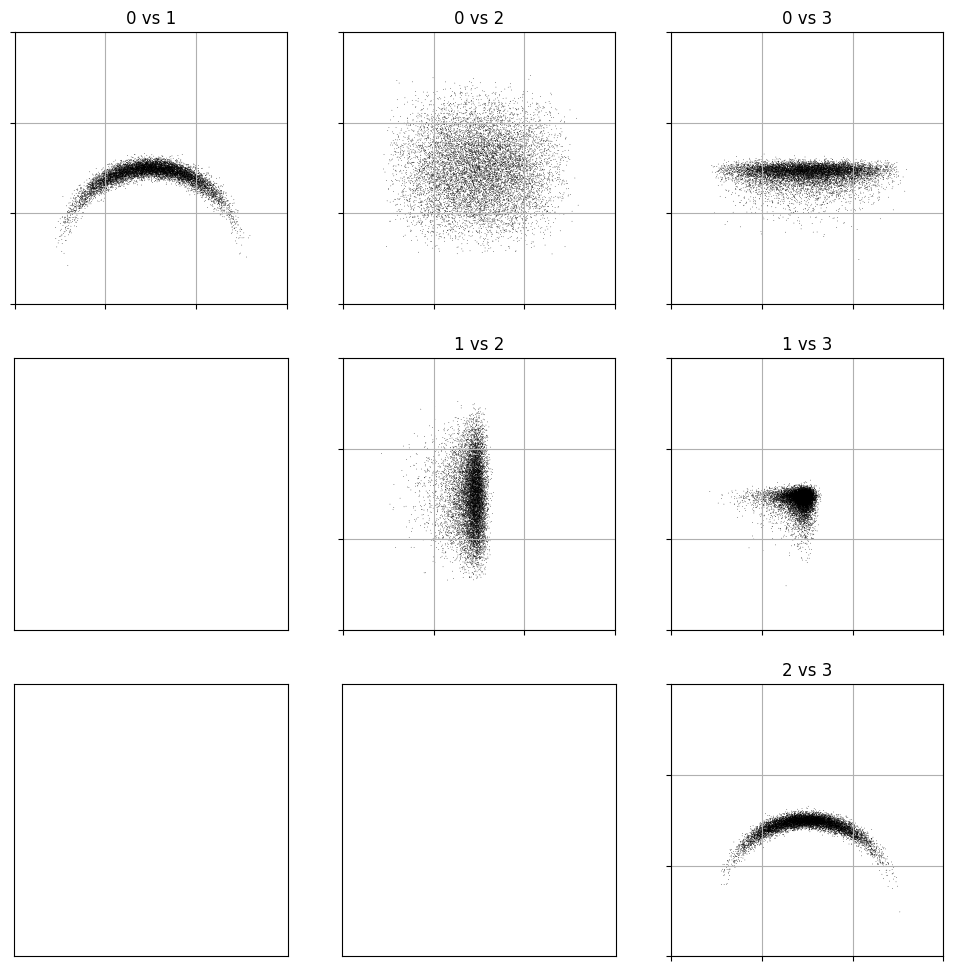

In [40]:
dims_plot_test = [0, 1, 2, 3]
fig, ax = plt.subplots(len(dims_plot_test)-1, len(dims_plot_test)-1, figsize=(12, 12), constrained_layout=False, squeeze=True)
x_range = [-1.5, 1.5]
y_range = [-1.5, 1.5]
#delete all ticks 
plt.setp(ax, xticks=[], yticks=[])
plt.setp(ax, xlabel='', ylabel='')

i = 0
for dim_1 in dims_plot_test:
    for dim_2 in dims_plot_test:
        if dim_1 <= dim_2:
            continue
        #show title
        #ax[i].set_title(f'{dim_2} vs {dim_1}, original')
        #plot_data(x_orig, ax[i], dim_2, dim_1, color='b', s=0.01, x_range=x_range, y_range=y_range)
        
        ax_temp = ax[dim_2, dim_1-1]
        ax_temp.set_title(f'{dim_2} vs {dim_1}')
        plot_data(x_orig.cpu().detach().numpy(), ax_temp, dim_2, dim_1, color='black', s=1, x_range=x_range, y_range=y_range)
        ax_temp.set_xticks(ticks=np.arange(x_range[0], x_range[1]+1, 1), labels=[])
        ax_temp.set_yticks(ticks=np.arange(y_range[0], y_range[1]+1, 1), labels=[])
        ax_temp.grid(True)

        i += 1
plt.show()

## Training

In [41]:
flow, optimizer_flow, losses = INN_init(N_DIM = kwargs_data['N_dim'], N_blocks = 10, coupling_block = 'GLOW', ch_hidden=128, permute_soft=False, permute_hard=True, use_actnorms=True, lr=1e-3, device=kwargs_data['device'])

In [42]:
kwargs_loss = {
    'batch_size': 1024*10,
    'use_PF_exact': True, #additionally minimize the Manifold Total Correlation via the brute force method
    'alpha': 1,
    'use_rec': False, #additionally minimize reconstruction loss via MSE
    'lam_rec': 100,
    'dims_rec': torch.arange(N_dim//2), #latent dimensions which are set to zero for reconstruction loss
    'use_latent_sorting': False
}

In [ ]:
data_function = (lambda batchsize: get_data(kwargs_data, N_samples=batchsize))
train(flow, data_function, optimizer_flow, losses, kwargs_data, kwargs_loss, N_iter=1000)

In [63]:
optimizer_flow.param_groups[0]['lr'] = 1e-4

In [ ]:
#plot loss
plt.figure(figsize=(15, 5))

plt.title('ML loss')
plt.plot(losses['ML'])
plt.grid()

plt.show()

## Qualitative and Manifold Entropic Evaluation

In [46]:
# sample from the model and compute the Jacobian via backward autodiff
jac_gen, ljd_gen, z_gen, x_gen = get_decoder_jac(flow, kwargs_data, N_samples=10000, print_info=False)

# compute the manifold entropy and total entropy of the model, latent_sort is the sorted indices of the latent dimensions according to their entropy
H_i, H_full, latent_sort = get_manifold_entropy(kwargs_data, jac_gen, ljd_gen, print_info=False)

#sort the latent dimensions by the entropy
H_i_sort = H_i[latent_sort].cpu().detach().numpy()

#compute the manifold total correlation
MTC = (H_i.sum() - H_full).item()
H_full = H_full.item()

print('Manifold Total Corelation between all latent dimensions:', MTC)
print('Full Entropy (normalized):', H_full/N_dim)

Manifold Total Corelation between all latent dimensions: 0.4605236053466797
Full Entropy (normalized): -1.206075954437256


### Generated samples

In [47]:
#apply rot in reverse
rot = kwargs_data['rot']
x_gen_unrotated = torch.mm(torch.tensor(x_gen).to(rot.device), rot.t())
x_gen_unrotated = x_gen_unrotated.cpu().detach().numpy()

/tmp/ipykernel_2665799/2700720786.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_unrotated = torch.mm(torch.tensor(x_gen).to(rot.device), rot.t())


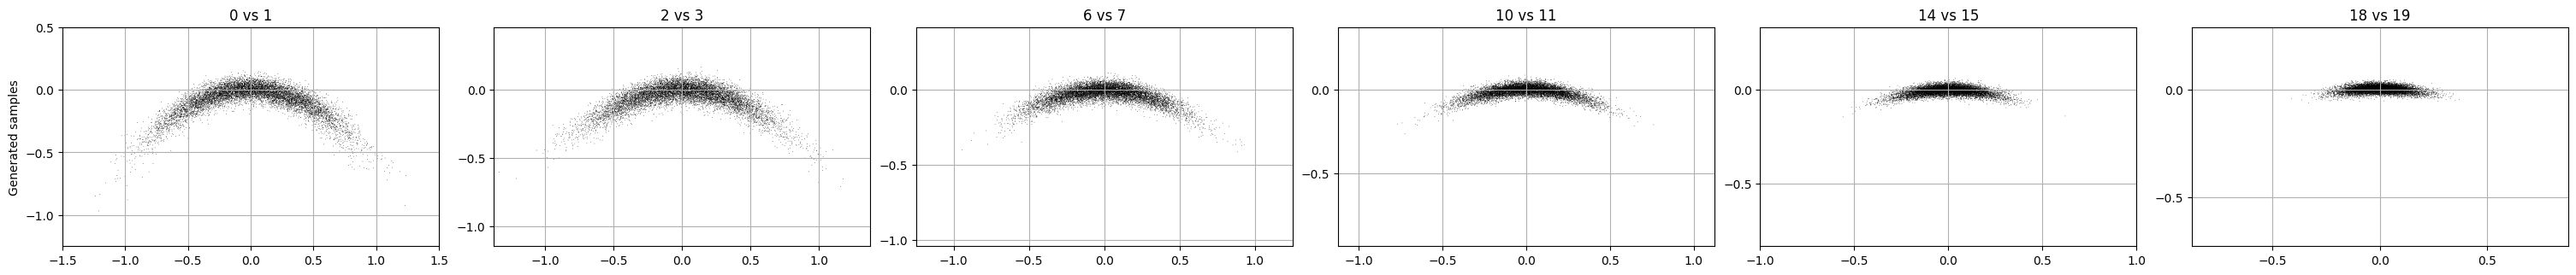

In [48]:
fig, ax = plt.subplots(1, len(dims_plot), figsize=(30, 6), constrained_layout=True, squeeze=False)

i = 0
ax[0, 0].set_ylabel('Generated samples')

for dim_1 in dims_plot:
    dim_2 = dim_1 + 1
    ax[0, i].set_title(f'{dim_1} vs {dim_2}')

    x_scale = 1.5-1*(i/8) #1.5*(1+i)**(-1.0) #1.5-1*(i/8) #1.5-1*(i/4)
    x_range, y_range = [-x_scale, x_scale], [-(x_scale/1.2), (x_scale/3)]

    plot_data(x_gen_unrotated, ax[0, i], dim_1, dim_2, color='black', s=1, alpha=1, marker='.', x_range=x_range, y_range=y_range)
    ax[0, i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0, i].yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0, i].grid(True)

    i += 1
plt.show()

### Generated contour grid

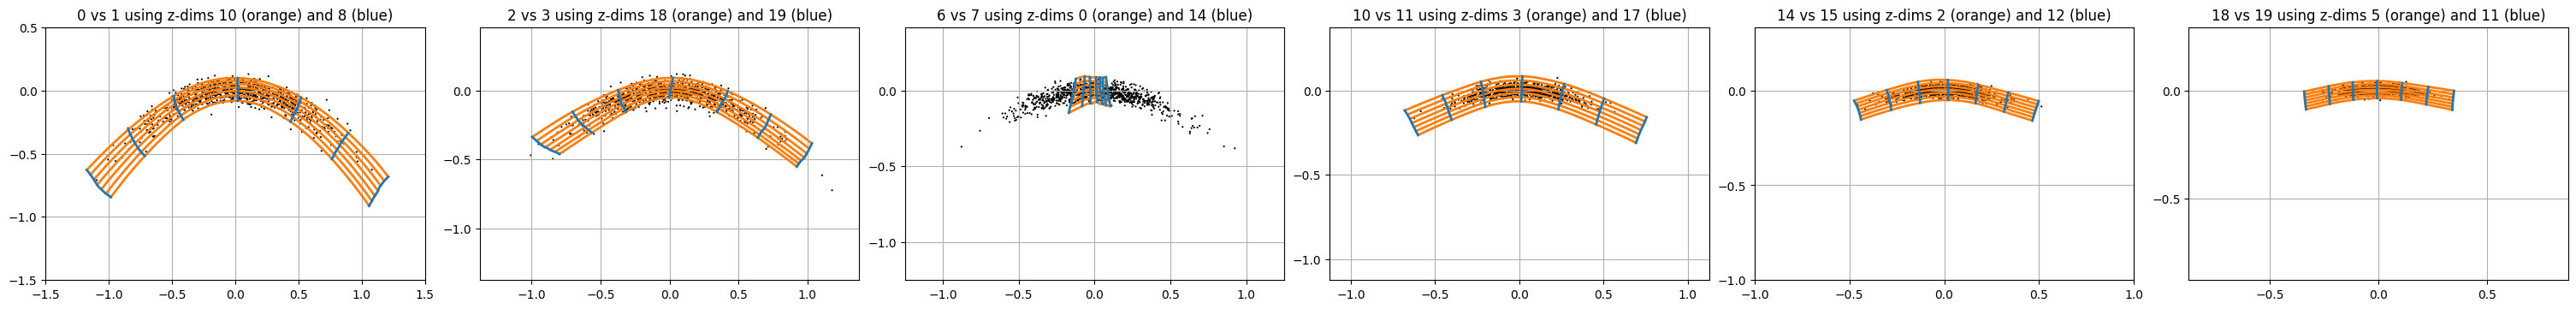

In [49]:
fig, axes = plt.subplots(1, len(dims_plot), figsize=(30, 6), constrained_layout=True)

dims_plot_x = dims_plot
dims_plot_y = dims_plot+1

dims_plot_xy = np.array([dims_plot_x, dims_plot_y]).T

for i, dims in enumerate(dims_plot_xy):
    x_dims = np.array([dims[0], dims[1]])
    z_dims = np.array([latent_sort[dims[0]//2], latent_sort[dims[0]//2 + N_dim//2]])
    #print('x_dims:', x_dims, 'z_dims:', z_dims)
    ax = axes[i]
    ax.set_aspect('equal')

    x_scale = 1.5-1*(i/8) #1.5-1*(i/4)
    x_range, y_range = [-x_scale, x_scale], [-(x_scale/1), (x_scale/3)]
    title = f'{x_dims[0]} vs {x_dims[1]} using z-dims {z_dims[0]} (orange) and {z_dims[1]} (blue)'

    plot_contour_grid_torus(flow, kwargs_data, ax, z_dims=z_dims, x_dims=x_dims, BATCHSIZE_samples=1000, show_samples=True, show_contour_grid=True,
                title=title, fontsize=12, x_range=x_range, y_range=y_range, N_maj_ticks = 7, N_min_ticks = 20,
                samples_size=10, linewidth=2, grid_scaling=2)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.grid(True)

#plt.tight_layout()
plt.show()

### Manifold Entropy Spectrum

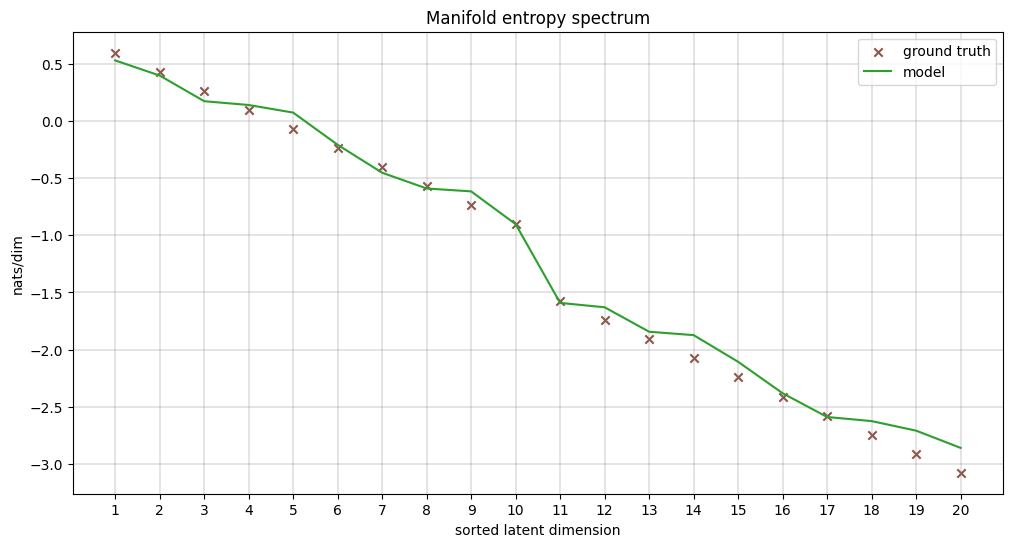

In [50]:
x_dims_array = np.arange(N_dim)+1
sigmas = kwargs_data['sigmas'].cpu().numpy()
x = np.arange(N_dim)
sigmas = np.sort(sigmas)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Manifold entropy spectrum')
plt.scatter(x_dims_array, 1/2*(1 + np.log(2*np.pi)) + np.log(sigmas), label='ground truth', marker='x', color='tab:brown')
plt.plot(x_dims_array, H_i_sort, label='model', color='tab:green')

plt.grid(color = 'gray', linestyle = '-', linewidth = 0.3)
plt.xticks(x_dims_array)
plt.ylabel('nats/dim')
plt.xlabel('sorted latent dimension')
plt.legend()
plt.show()

### Pearson Correlation Matrix and MCPMI

In [51]:
def get_Pearson(z_gt, z_pred):
    """
    Compute the (linear) Pearson correlation between all ground truth and predicted latent space variables
    """
    # Normalize z_gt and z_pred
    z_gt   = (z_gt - z_gt.mean(0).unsqueeze(0))/z_gt.std(0).unsqueeze(0)
    z_pred = (z_pred - z_pred.mean(0).unsqueeze(0))/z_pred.std(0).unsqueeze(0)

    pearson_corr = torch.einsum('ij,ik->jk', z_pred, z_gt)/(z_gt.shape[0])
    return pearson_corr.detach().cpu().numpy()

In [52]:
# get ground truth samples, latent vectors and jacobian from known DGP
x_gt, z_gt, jac_gt = get_data(kwargs_data, N_samples=10000, get_all=True)
# compute model decoder Jacobian
jac_gen, _, z_rec, x_rec = get_decoder_jac(flow, kwargs_data, N_samples=1000, x_input=x_gt, print_info=True)
# sort Jacobian columns by the manifold entropy of the corresponding latent dimension
jac_gen = jac_gen[:,latent_sort]

Computing Jacobian with backward autodiff


100%|██████████| 20/20 [00:00<00:00, 113.54it/s]


Compare ground truth decoder with model decoder via Pearson correlation and Manifold Cross-Pairwise Mutual Information (MCPMI)

In [53]:
pearson_corr = get_Pearson(z_gt, z_rec[:,latent_sort])
MCPMI_gen_gt = get_manifold_pairwise_mutual_information(jac_gen, jac_gt).detach().cpu().numpy()

Computing MCPMI matrix


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 53.62it/s]


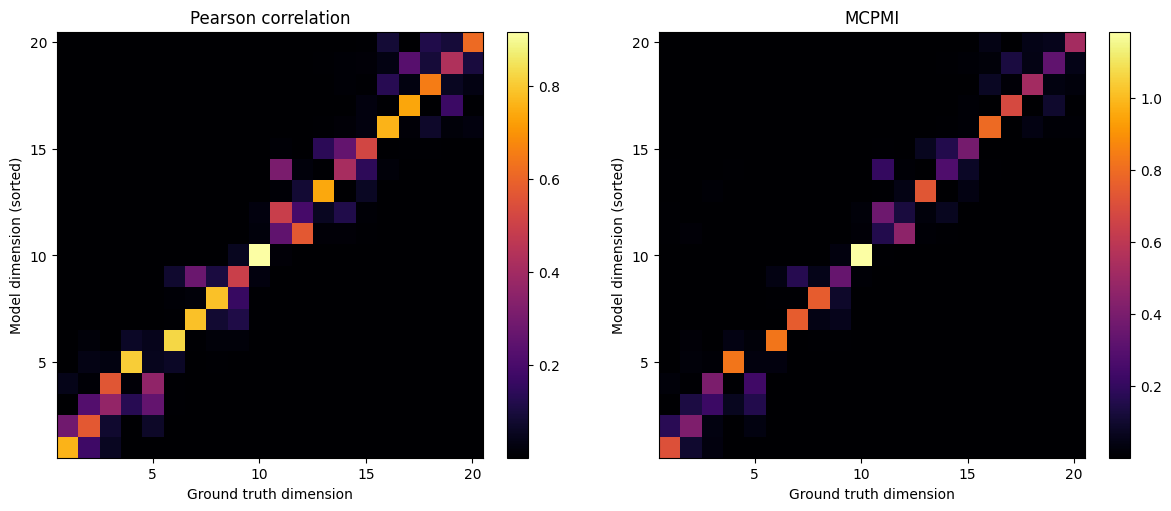

In [54]:
plt.figure(figsize=(12, 5), constrained_layout=True)

scale_fct = lambda x: x**2

plt.subplot(1, 2, 1)
plt.imshow(scale_fct(np.flip(pearson_corr, axis=0)), cmap='inferno', interpolation='nearest', extent=[0, N_dim, 0, N_dim])
plt.xticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.yticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.xlabel('Ground truth dimension') #?
plt.ylabel('Model dimension (sorted)') #?

plt.colorbar()
plt.title('Pearson correlation')

plt.subplot(1, 2, 2)
plt.imshow(np.flip(MCPMI_gen_gt, axis=0), cmap='inferno', interpolation='nearest', extent=[0, N_dim, 0, N_dim])#, vmax=0.1)
plt.xticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.yticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.xlabel('Ground truth dimension') #?
plt.ylabel('Model dimension (sorted)') #?
plt.colorbar()
plt.title('MCPMI')

plt.show()

Measure Manifold Pairwise Mutual Information (MPMI) once of the ground truth decoder and once of the model decoder

In [55]:
MPMI_gen = get_manifold_pairwise_mutual_information(jac_gen, jac_gen).detach().cpu().numpy()
MPMI_gt = get_manifold_pairwise_mutual_information(jac_gt, jac_gt).detach().cpu().numpy()

Computing MPMI matrix


100%|██████████| 20/20 [00:00<00:00, 231.79it/s]


Computing MPMI matrix


100%|██████████| 20/20 [00:00<00:00, 126.08it/s]


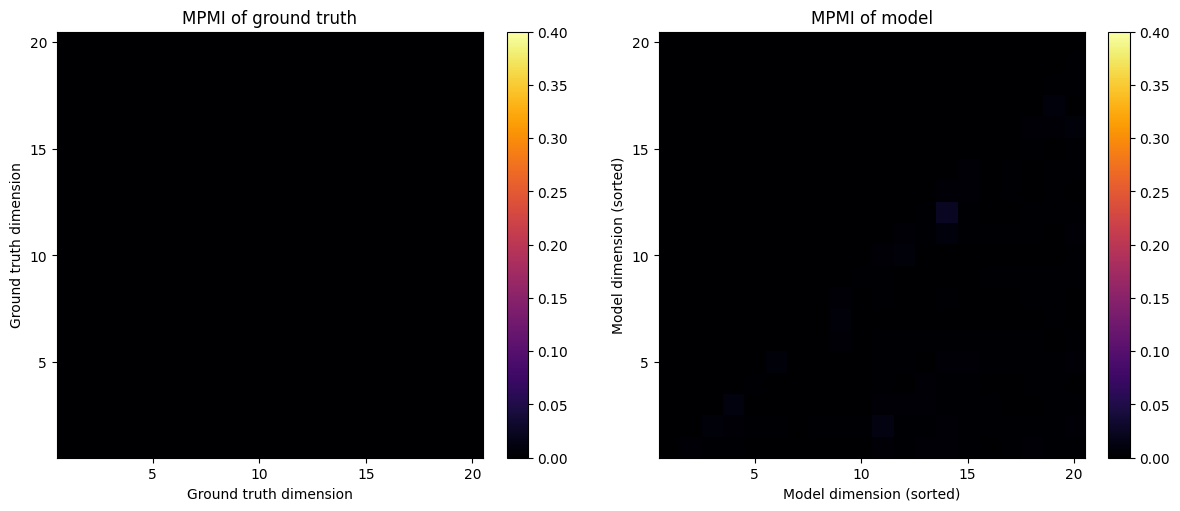

In [56]:
plt.figure(figsize=(12, 5), constrained_layout=True)

vmax = 0.4

plt.subplot(1, 2, 1)
plt.title('MPMI of ground truth')
plt.imshow(np.flip(MPMI_gt, axis=0), cmap='inferno', interpolation='nearest', extent=[0, N_dim, 0, N_dim], vmax=vmax)
plt.xticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.yticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.xlabel('Ground truth dimension') #?
plt.ylabel('Ground truth dimension') #?
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('MPMI of model')
plt.imshow(np.flip(MPMI_gen, axis=0), cmap='inferno', interpolation='nearest', extent=[0, N_dim, 0, N_dim], vmax=vmax)
plt.xticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.yticks(np.arange(4, N_dim, 5)+0.5, labels=np.arange(5, N_dim+1, 5))
plt.xlabel('Model dimension (sorted)') #?
plt.ylabel('Model dimension (sorted)') #?
plt.colorbar()

plt.show()

We see that the MPMI of the ground truth is essentially zero as the transformation is made to be orthonormal everywhere.